# Generate a Marketing Video with Veo 3

In this demo, we'll create a marketing video for Brain Fuel, a fictional hydration drink, using two different approaches:

- **Scene 1: Text-to-video generation** - Generate a complete video from just a text prompt
- **Scene 2: Image-to-video generation** - Start with a specific product image and animate it

The text-to-video approach is quick and flexible, but gives you less control over specific details like product appearance. The image-to-video approach lets you maintain exact product branding by using an existing image as the first frame.

## Setup

Remember to set up your credentials:
```bash
cp env.example .env
```
then edit .env and add your Gemini API key.

First, install and import the required libraries.

In [ ]:
import time
import dotenv
import os
from google import genai
from PIL import Image
from io import BytesIO

dotenv.load_dotenv()

assert os.getenv("GEMINI_API_KEY"), "Please set the GEMINI_API_KEY environment variable"

# Only needed on the Udacity workspace. Comment this out if running on another system.
os.environ['HF_HOME'] = '/voc/data/huggingface'
os.environ['OLLAMA_MODELS'] = '/voc/data/ollama/cache'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['PATH'] = f"/voc/data/ollama/bin:/voc/data/ffmpeg/bin:{os.environ.get('PATH', '')}"
os.environ['LD_LIBRARY_PATH'] = f"/voc/data/ollama/lib:/voc/data/ffmpeg/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"

# Initialize the client
client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))

## Scene 1: Text-to-Video Generation

In this first scene, we'll generate everything from a text prompt. This is the simplest approach - just describe what you want and let Veo 3 create it.

The tradeoff is that you have less control over specific details. For example, the Brain Fuel can will be generated by the model, so it might not match your exact product design.

In [ ]:
scene1_prompt = """
A student is working on her laptop at a wooden desk in a cozy, dimly lit room in the evening.

She reaches out for a can of Brain Fuel on the desk, picks it up, and takes a sip.
She then turns to the camera and says: "Brain Fuel, my favorite water for studying".

The can features a sleek, modern design with the Brain Fuel logo prominently displayed 
and a tagline that reads "Hydrate Your Mind". The can also features a colorful
geometric pattern that suggests energy and focus.

Warm moody lighting
with practical amber lamps creating pools of light and soft shadows,
cozy evening study atmosphere. Color palette features warm wood tones,
amber lamplight.
Shallow depth of field, cinematic, realistic. 
"""

print("Generating Scene 1...")
operation = client.models.generate_videos(
    model="veo-3.0-generate-001",
    prompt=scene1_prompt,
)

# Poll until the video is ready
while not operation.done:
    print("Waiting for video generation to complete...")
    time.sleep(10)
    operation = client.operations.get(operation)

# Download the video
scene1_video = operation.response.generated_videos[0]
client.files.download(file=scene1_video.video)
scene1_video.video.save("text-to-video.mp4")
print("Scene 1 saved to text-to-video.mp4")


In [1]:
from IPython.display import display, Video

display(Video("text-to-video.mp4", embed=False))

## Scene 2: Image-to-Video Generation

For our second scene, we'll use a different approach that gives us more control over the product appearance. This is more realistic for actual marketing use cases where you already have product photography.

The workflow is:
1. Start with a product image (in a real scenario, you'd have this from your design team)
2. Use that image as the first frame of the video
3. Animate it with Veo 3

For this demo, we'll generate the product image using Gemini's image generation, but in practice you'd use your actual product photos.

### Step 1: Generate the Product Image

In a real marketing workflow, you'd already have professional product photography. For this demo, we'll generate one using Gemini's image generation capabilities.

In [ ]:
client = genai.Client()

prompt = (
    """
    An extreme close-up shot of a sleek aluminum bottle of an hydration drink, condensation 
    beading on its metallic surface with the label "Brain Fuel - Hydrate Your Mind" clearly 
    visible in modern typography. The bottle is decorated with a colorful and inspiring 
    pattern. The bottle is placed on a table in a room where a warm desk lamp casts soft 
    focused light.
    """
)

response = client.models.generate_content(
    model="gemini-2.5-flash-image",
    contents=[prompt],
)

for part in response.candidates[0].content.parts:
    if part.text is not None:
        print(part.text)
    elif part.inline_data is not None:
        image = Image.open(BytesIO(part.inline_data.data))
        image.save("brain_fuel_product.png")

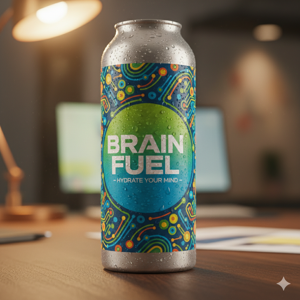

In [51]:
img = Image.open("brain_fuel_product.png")
img.thumbnail((300, 300))
img

### Step 2: Animate the Product Image

Now we'll use Veo 3's image-to-video capability to animate this product shot. The image becomes the first frame of the video, ensuring our product looks exactly as intended.

In [ ]:
from google.genai import types

# Load the product image
with open("brain_fuel_product.png", "rb") as f:
    image_bytes = f.read()

# Create an image part
starting_frame = types.Image(
    image_bytes=image_bytes,
    mime_type="image/png",
)

In [ ]:
scene2_prompt = """
The camera pulls back while a student opens the can and takes a sip.

The face of the student is not shown, only their hands. The student is
sitting at a desk with an open laptop in front of them, and a lamp
casting a warm glow. 

The lighting is warm and intimate - amber desk
lamp glow creating soft highlights on the aluminum can and wooden desk
surface, with bokeh lights softly blurred in the background, creating
a focused evening study atmosphere. The scene has rich warm tones with
pools of golden lamplight. 

Audio: hand touching the aluminum can with
a light metallic brush, a voice that says "Brain Fuel, Hydrate Your
Mind".
"""

print("Generating Scene 2...")
operation = client.models.generate_videos(
    model="veo-3.0-generate-001",
    prompt=scene2_prompt,
    image=starting_frame,
)

# Poll until the video is ready
while not operation.done:
    print("Waiting for video generation to complete...")
    time.sleep(10)
    operation = client.operations.get(operation)

# Download the video
scene2_video = operation.response.generated_videos[0]
client.files.download(file=scene2_video.video)
scene2_video.video.save("image-to-video.mp4")
print("Scene 2 saved to image-to-video.mp4")

In [5]:
display(Video("image-to-video.mp4", embed=False))

## Comparing the Two Approaches

You now have two video clips demonstrating different generation approaches:

**Text-to-Video (Scene 1)**
- Fastest and simplest approach
- Less control over specific visual details
- Best for rapid prototyping and concept exploration

**Image-to-Video (Scene 2)**
- More control over product appearance and branding
- Ensures consistency with existing product photography
- Best for final production when brand accuracy matters

In a real marketing workflow, you'd typically use text-to-video for initial concepts and image-to-video for the final product shots.